In [ ]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from shapely.geometry import Polygon, MultiPoint
import cv2

### Prepare data from ChEMBL raw source

In [ ]:
import pandas as pd

# ChEMBL 31 (https://chembl.gitbook.io/chembl-interface-documentation/downloads)
df = pd.read_csv('chembl_31_chemreps.txt', sep='\t')
df.head()

In [ ]:
# inchi type raise missing structures.
df = df.drop(columns=['standard_inchi', 'standard_inchi_key'])

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors

def get_molecular_weight(smi):
    try:
        _mol = Chem.MolFromSmiles(smi)
        return Descriptors.MolWt(_mol)
    except:
        print(smi)
        return 0

def check_ion(smi):
    if '.' in smi:
        return 1
    return 0

def rewrite_chembl_id(x):
    # _length = len(x)
    _numbers = int(x[6:])
    return f"CHEMBL{_numbers:07d}"

In [ ]:
df = df.sample(frac=0.1)
df['has_ion'] = df['canonical_smiles'].apply(check_ion)
df = df.loc[df['has_ion'] == 0]
df['mol_weight'] = df['canonical_smiles'].apply(get_molecular_weight)
df = df.loc[(df['mol_weight'] < 600) & (df['mol_weight'] > 10)]
df['chembl_id'] = df['chembl_id'].apply(rewrite_chembl_id)

In [ ]:
df.to_csv('chembl_31_smiles_sample.csv', index=False)

In [ ]:
df.head()

### Prepare data from `chembl_31_smiles_sample.csv`

In [ ]:
import pandas as pd

df = pd.read_csv('chembl_31_smiles_sample.csv')
df.head()

In [ ]:
# df_train = df.sample(frac=0.2)
df_train = df.loc[df['has_wedge'] == 1].sample(frac=0.5)
df_val = df.loc[~df.index.isin(df_train.index)].sample(frac=0.01)
df_test = df.loc[(~df.index.isin(df_train.index)) & (~df.index.isin(df_val.index))].sample(frac=0.02)

In [ ]:
df_train.to_csv('chembl_31_smiles_train.csv', index=False)
df_val.to_csv('chembl_31_smiles_val.csv', index=False)
df_test.to_csv('chembl_31_smiles_test.csv', index=False)

### Prepare data from predefined data of this repo

In [1]:
import pandas as pd

from targets import DBNetTargets
from chem import MolSVG

targets = DBNetTargets(shrink_ratio=0.5)

In [ ]:
!tar xzf chembl_31_smiles_learning_data.csv.tar.gz

In [2]:
train = pd.read_csv('chembl_31_smiles_train.csv')
eval = pd.read_csv('chembl_31_smiles_val.csv')
test = pd.read_csv('chembl_31_smiles_test.csv')

df = pd.concat([train, eval, test])

In [ ]:
from pathlib import Path
from PIL import Image

def save_image(idx):
    _id = df.iloc[idx, 0]
    _smi = df.iloc[idx, 1]
    _dir = f"{HOME_DIR}/{_id[6]}/{_id[7]}/{_id[8]}/{_id[9]}/{_id[10]}"
    if not Path(f"{_dir}/{_id}.thr_mask.png").exists():
        Path(_dir).absolute().mkdir(parents=True, exist_ok=True)
        mol_svg = MolSVG(_smi)
        x = mol_svg.image
        y = targets.generate_targets(mol_svg)
        pil_image = Image.fromarray(x)
        pil_image.save(f"{_dir}/{_id}.png")
        pil_img_shr = Image.fromarray(y['gt_shr'])
        pil_img_shr.save(f"{_dir}/{_id}.shr.png")
        pil_img_shr_mask = Image.fromarray(y['gt_shr_mask'])
        pil_img_shr_mask.save(f"{_dir}/{_id}.shr_mask.png")
        pil_img_thr = Image.fromarray(y['gt_thr'])
        pil_img_thr.save(f"{_dir}/{_id}.thr.png")
        pil_img_thr_mask = Image.fromarray(y['gt_thr_mask'])
        pil_img_thr_mask.save(f"{_dir}/{_id}.thr_mask.png")

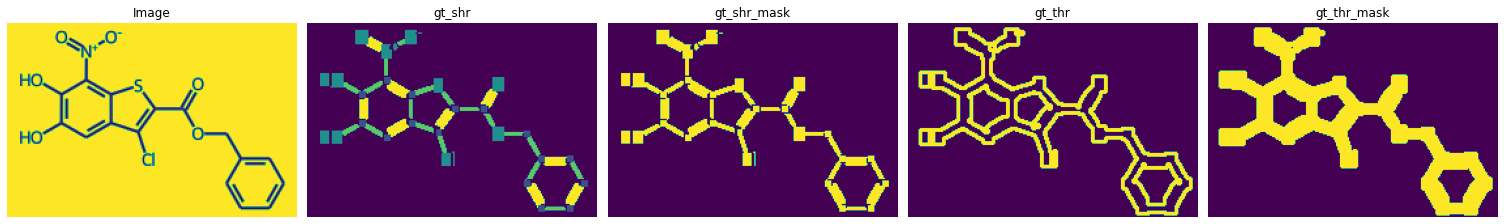

In [5]:
from matplotlib import pyplot as plt

targets = DBNetTargets(shrink_ratio=0.5)

# _smi = 'CN(C)CCOc1cc(NC(=O)Nc2cccc([N+](=O)[O-])c2)ccc1I'
_smi = 'O=C(OCc1ccccc1)c1sc2c([N+](=O)[O-])c(O)c(O)cc2c1Cl'

mol_svg = MolSVG(_smi)
x = mol_svg.image
y = targets.generate_targets(mol_svg)

fig, ax = plt.subplots(1, 5, figsize=(21, 4), sharex=True, sharey=True)
ax[0].imshow(x)
ax[0].axis('off')
ax[0].set_title('Image')
ax[1].imshow(y['gt_shr'])
ax[1].axis('off')
ax[1].set_title('gt_shr')
ax[2].imshow(y['gt_shr_mask'])
ax[2].axis('off')
ax[2].set_title('gt_shr_mask')
ax[3].imshow(y['gt_thr'])
ax[3].axis('off')
ax[3].set_title('gt_thr')
ax[4].imshow(y['gt_thr_mask'])
ax[4].axis('off')
ax[4].set_title('gt_thr_mask')

In [ ]:
from multiprocessing import Pool

HOME_DIR = '../../Data/ChEMBL/OCR'

_index = [_ for _ in range(len(df))]

with Pool(16) as pool:
    pool.map(save_image, _index, chunksize=8)

# 5 min; used 16 core of AMD Ryzen 5800X; 22052 smiles to image